In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

In [0]:
epoch = 50
batch_size = 512
learning_rate = 0.0002
num_gpus = 1
z_size = 50
middle_size = 200

In [0]:
mnist_train = dset.MNIST("./",train=True,transform=transforms.ToTensor(),target_transform=None,download=True)
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True,drop_last = True)

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(OrderedDict([('fc1',nn.Linear(z_size,middle_size)),('bn1',nn.BatchNorm1d(middle_size)),('act1',nn.ReLU()),]))
        self.layer2 = nn.Sequential(OrderedDict([('fc2',nn.Linear(middle_size,784)),('tanh',nn.Tanh()),]))
    
    def forward(self,z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = out.view(batch_size,1,28,28)
        return out

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(OrderedDict([('fc1',nn.Linear(784,middle_size)),('act1',nn.LeakyReLU()),]))
        self.layer2 = nn.Sequential(OrderedDict([('fc2',nn.Linear(middle_size,1)),('bn2',nn.BatchNorm1d(1)),('act2',nn.Sigmoid()),]))
    
    def forward(self,x):
        out = x.view(batch_size,-1)
        out = self.layer1(out)
        out = self.layer2(out)
       
        return out


In [0]:
generator = nn.DataParallel(Generator()).cuda()
discriminator = nn.DataParallel(Discriminator()).cuda()

In [80]:
gen_params = generator.state_dict().keys()
dis_params = discriminator.state_dict().keys()

for i in gen_params:
    print(i)

module.layer1.fc1.weight
module.layer1.fc1.bias
module.layer1.bn1.weight
module.layer1.bn1.bias
module.layer1.bn1.running_mean
module.layer1.bn1.running_var
module.layer1.bn1.num_batches_tracked
module.layer2.fc2.weight
module.layer2.fc2.bias


In [81]:
generator.state_dict()  # model's weight and bias

OrderedDict([('module.layer1.fc1.weight',
              tensor([[ 0.0465, -0.0365, -0.0603,  ...,  0.1239,  0.0040, -0.1383],
                      [ 0.0120,  0.0760,  0.0708,  ..., -0.0749, -0.1108,  0.0778],
                      [ 0.0040,  0.0371, -0.0213,  ...,  0.0716,  0.0903,  0.0371],
                      ...,
                      [ 0.0929, -0.0101, -0.0841,  ...,  0.0663,  0.0400,  0.0280],
                      [-0.0237,  0.1087, -0.0690,  ..., -0.0859,  0.0306,  0.1139],
                      [ 0.0792,  0.1213,  0.0997,  ..., -0.0698, -0.0814,  0.1053]],
                     device='cuda:0')),
             ('module.layer1.fc1.bias',
              tensor([-0.0799, -0.0978, -0.0830, -0.1136, -0.0353, -0.1163, -0.0716, -0.0077,
                      -0.0543,  0.0323, -0.1201,  0.0483, -0.0880, -0.0420, -0.1260, -0.1248,
                       0.0864, -0.1145,  0.1338, -0.0291,  0.0616,  0.1381, -0.1046,  0.0063,
                       0.1131, -0.0870, -0.0099,  0.1081,  0.134

In [0]:
loss_func = nn.MSELoss()
gen_optim = torch.optim.Adam(generator.parameters(),lr=learning_rate,betas=(0.5,0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(),lr=learning_rate,betas=(0.5,0.999))

one_label = torch.ones(batch_size,1).cuda()
zero_label = torch.zeros(batch_size,1).cuda()

In [104]:
for i in range(epoch):
    for j,(image,label) in enumerate(train_loader):
        #discriminator
        dis_optim.zero_grad()
        z = init.normal(torch.Tensor(batch_size,z_size),mean=0,std=0.1).cuda()
        gen_fake = generator(z)
        dis_fake = discriminator.forward(gen_fake)

        dis_real = discriminator.forward(image)
        dis_loss = torch.sum(loss_func(dis_fake,zero_label))+torch.sum(loss_func(dis_real,one_label))
        dis_loss.backward(retain_graph=True)
        dis_optim.step()
        #generator
        gen_optim.zero_grad()
        z = init.normal(torch.Tensor(batch_size,z_size),mean=0,std=0.1).cuda()
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)
        gen_loss = torch.sum(loss_func(dis_fake,one_label))
        gen_loss.backward()
        gen_optim.step()

        if j %100 ==0:
            print(gen_loss,dis_loss)
            torch.save([generator,discriminator],"./content")
            print("{}th iteration gen_loss: {} dis_loss: {}".format(i,gen_loss.data,dis_loss.data))
            torchvision.utils.save_image(gen_fake.data[0:25],"img{}_{}.png".format(i,j),nrow=5)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


tensor(0.2562, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.5439, device='cuda:0', grad_fn=<AddBackward0>)
0th iteration gen_loss: 0.25620219111442566 dis_loss: 0.5439371466636658
tensor(0.2808, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4851, device='cuda:0', grad_fn=<AddBackward0>)
0th iteration gen_loss: 0.28075090050697327 dis_loss: 0.48510757088661194
tensor(0.2777, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4918, device='cuda:0', grad_fn=<AddBackward0>)
1th iteration gen_loss: 0.27768006920814514 dis_loss: 0.491839200258255
tensor(0.2508, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.5212, device='cuda:0', grad_fn=<AddBackward0>)
1th iteration gen_loss: 0.2507583498954773 dis_loss: 0.5211573839187622
tensor(0.2506, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.5273, device='cuda:0', grad_fn=<AddBackward0>)
2th iteration gen_loss: 0.2506335377693176 dis_loss: 0.5273072719573975
tensor(0.2943, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4804, device

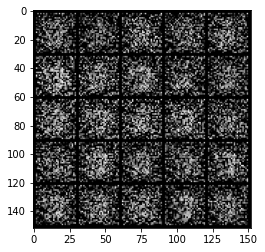

In [127]:
from PIL import Image
img =  Image.open('img1_0.png').convert('RGB')
plt.imshow(img)